In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from pylab import*
import seaborn as sns
import numpy as np
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)
from scipy.stats import kstest
from optbinning import OptimalBinning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from pylab import*
import seaborn as sns


from itertools import cycle


from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

## función para la curva ROC

In [2]:
def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f} \n GINI = {2*roc_auc-1:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

## importar datos

In [3]:
#importar los datos
datos_ext='base_ini_externa.txt'
datos_int='base_ini_interna.csv'
datos_pt1='base_ini_parte1.csv'
datos_comp3='base_comportamiento_3.csv'
datos_comp2='base_comportamiento_2.txt'
datos_inicio='bd_inicio_parte1.txt'
datos_inv='base_inversion.txt'

b_comp3=pd.read_csv(datos_comp3)
b_comp2=pd.read_csv(datos_comp2,delimiter=' ')
b_inicio=pd.read_csv(datos_inicio,delimiter=' ')
b_int=pd.read_csv(datos_int)
b_ext=pd.read_csv(datos_ext,delimiter=' ')
b_pt1=pd.read_csv(datos_pt1)
b_inv=pd.read_csv(datos_inv,delimiter=' ')

## Tratamiento y limpieza de datos

In [4]:
#unir las bases de las variables
merge_t = b_inicio.merge( b_int, on="_id_").merge(b_ext, on='_id_').merge(b_pt1, on='_id_').merge(b_inv,on='_id2_') #unimos las bases
merge_t['num_caso']=merge_t['_id_']  
merge_t=merge_t.set_index('num_caso') #agregamos los id como indices
merge_t=merge_t.sort_values(by=['_id_'])  

#unir las bases de las variables
comportamiento=pd.merge(b_comp3,b_comp2, how='outer', left_index=True, right_index=True)  #unimos las bases de comportamiento
comportamiento=comportamiento.drop(['mes_informacion_y'], axis=1)     #eliminamos las columnas repetidas
comportamiento=comportamiento.rename(columns={"num_caso_x": "_id_",'num_caso_y':'num_caso'})  #renombramos


In [5]:
comp=comportamiento.groupby(['num_caso']) #agrupar el comportamiento por num caso
#hacemos un data frame que contenga el numero de atrasos entre días, si el cociente es 1 significa que no pagó
pr=pd.DataFrame({'comp':comp['comportamiento_j'].sum()/comp['Tiempo_aparicion'].sum()})
pr['_id_']=pr.index #agregamos la columna _id_ para cruzarla con las demas tablas

In [6]:
n=0.05
len(pr.loc[pr['comp']>=n]) #personas que no pagarón o se atrasaron, entre más cerca de 1 es que no paga

2891

In [7]:
pr=pr.sort_values(by=['_id_'])#ordenar por id
pr['_id_']=pr['_id_'].astype(int)

In [8]:
pr['pr_bin']=pr['comp']                   #copiamos la columna
pr.loc[pr['comp']>=n,'pr_bin']=1    # filtramos con 0 o 1 según su cociente de pr['comp'], 0 no paga
pr.loc[pr['comp']<n,'pr_bin']=0     #1 si paga

In [9]:
tab=merge_t.merge(pr,on='_id_', how="left") 
tab=tab.fillna(0.0)

In [10]:
cols=tab.columns

X=tab.loc[:,[cols[1],cols[3],cols[5],cols[7],cols[8],cols[9],cols[10],cols[11],cols[12],cols[13],cols[14], cols[15]]]
y=tab['pr_bin']
print(cols)

Index(['_id_', 'comp_interno4_x', 'fecha_inicio', 'comp_interno1',
       'comp_interno2', 'comp_interno3', 'comp_interno4_y', 'categoria1',
       'categoria2', 'categoria3', 'comp_externo1', 'comp_externo2',
       'comp_externo3', 'comp_externo4', '_id2_', 'comp_mixto1', 'inversion',
       'comp', 'pr_bin'],
      dtype='object')


## E1

In [11]:
tab['_id_'].value_counts(normalize=True)
tab['fecha_inicio'].value_counts(normalize=True)
tab['comp_interno1'].value_counts(normalize=True)
tab['comp_interno2'].value_counts(normalize=True)
tab['comp_interno3'].value_counts(normalize=True)
tab['comp_interno4_y'].value_counts(normalize=True)
tab['comp_mixto1'].value_counts(normalize=True)
tab['categoria2'].value_counts(normalize=True)
tab['categoria3'].value_counts(normalize=True)
tab['comp_mixto1'].value_counts(normalize=True)
tab['inversion'].value_counts(normalize=True)
tab['comp'].value_counts(normalize=True)
tab['categoria1'].value_counts(normalize=True)

1.0    0.407105
2.0    0.309820
3.0    0.242188
4.0    0.023837
5.0    0.008953
6.0    0.008098
Name: categoria1, dtype: float64

In [12]:
x = X.copy().values

In [13]:
train, test = train_test_split(tab, test_size = 0.30, random_state = 100)

In [14]:
######### eliminar celda
# x1=tab.loc[:,['comp_interno4_x','categoria1','comp_externo3', 'comp_mixto1']]
# X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y, test_size=0.2, random_state=123)

In [15]:
y1 = train.pr_bin

In [16]:
optb_Id = OptimalBinning(name="Id", dtype="numerical", solver="cp", cat_cutoff=0.1)
optb_fecha_inicio = OptimalBinning(name="fecha_inicio", dtype="categorical", solver="cp")
optb_comp_interno1 = OptimalBinning(name="comp_interno1", dtype="numerical", solver="cp", cat_cutoff=0.05)
optb_comp_interno2 = OptimalBinning(name="comp_interno2", dtype="categorical", solver="mip", cat_cutoff=0.05)
optb_comp_interno3 = OptimalBinning(name="comp_interno3", dtype="categorical", solver="mip", cat_cutoff=0.05)
optb_comp_interno4 = OptimalBinning(name="comp_interno4", dtype="categorical", solver="mip")
optb_categoria1 = OptimalBinning(name="categoria1", dtype="categorical", solver="mip",cat_cutoff =0.05)
optb_categoria2 = OptimalBinning(name="categoria2", dtype="categorical", solver="mip", cat_cutoff=0.05)
optb_categoria3 = OptimalBinning(name="categoria3", dtype="categorical", solver="mip", cat_cutoff=0.05)
optb_comp_externo1 = OptimalBinning(name="comp_externo1", dtype="numerical", solver="cp", cat_cutoff=0.05)
optb_comp_externo2= OptimalBinning(name="comp_externo2", dtype="numerical", solver="cp",cat_cutoff=0.05)
optb_comp_externo3 = OptimalBinning(name="comp_externo3", dtype="numerical", solver="cp",cat_cutoff=0.05)
optb_comp_externo4 = OptimalBinning(name="comp_externo4", dtype="numerical", solver="cp",cat_cutoff=0.05)
optb_Id2 = OptimalBinning(name="Id2", dtype="numerical", solver="cp",cat_cutoff=0.05)
optb_comp_mixto1 = OptimalBinning(name="comp_mixto1", dtype="numerical", solver="cp",cat_cutoff=0.05)
optb_inversion = OptimalBinning(name="inversion", dtype="numerical", solver="cp",cat_cutoff=0.05)
optb_comp = OptimalBinning(name="comp", dtype="numerical", solver="cp",cat_cutoff=0.05)

In [17]:
optb_Id.fit(train['_id_'].values, y1)
optb_fecha_inicio.fit(train["fecha_inicio"].values, y1)
optb_comp_interno1.fit(train["comp_interno1"].values, y1)
optb_comp_interno2.fit(train["comp_interno2"].values, y1)
optb_comp_interno3.fit(train["comp_interno3"].values, y1)
optb_comp_interno4.fit(train['comp_interno4_y'].values, y1)
optb_categoria1.fit(train["categoria1"].values, y1)
optb_categoria2.fit(train["categoria2"].values, y1)
optb_categoria3.fit(train["categoria3"].values, y1)
optb_comp_externo1.fit(train["comp_externo1"].values, y1)
optb_comp_externo2.fit(train["comp_externo2"].values, y1)
optb_comp_externo3.fit(train["comp_externo3"].values, y1)
optb_comp_externo4.fit(train["comp_externo4"].values, y1)
optb_Id2.fit(train['_id2_'].values, y1)
optb_comp_mixto1.fit(train["comp_mixto1"].values, y1)
optb_inversion.fit(train["inversion"].values, y1)
optb_comp.fit(train["comp"].values, y1)

OptimalBinning(cat_cutoff=0.05, name='comp')

In [18]:
Id_tab = optb_Id.binning_table
fecha_inicio_tab = optb_fecha_inicio.binning_table
comp_interno1_tab = optb_comp_interno1.binning_table
comp_interno2_tab = optb_comp_interno2.binning_table
comp_interno3_tab = optb_comp_interno3.binning_table
comp_interno4_tab = optb_comp_interno4.binning_table
categoria1_tab = optb_categoria1.binning_table
categoria2_tab = optb_categoria2.binning_table
categoria3_tab = optb_categoria3.binning_table
comp_externo1_tab = optb_comp_externo1.binning_table
comp_externo2_tab = optb_comp_externo2.binning_table
comp_externo3_tab = optb_comp_externo3.binning_table
comp_externo4_tab = optb_comp_externo4.binning_table
Id2_tab = optb_Id2.binning_table
comp_mixto1_tab = optb_comp_mixto1.binning_table
inversion_tab = optb_inversion.binning_table
comp_tab = optb_comp.binning_table

In [19]:
display('WOE Id', Id_tab.build())
display('WOE fecha_inicio', fecha_inicio_tab.build())
display('WOE comp_interno1', comp_interno1_tab.build())
display('WOE comp_interno2',comp_interno2_tab.build())
display('WOE comp_interno3',comp_interno3_tab.build())
display('WOE comp_interno4',comp_interno4_tab.build())
display('WOE categoria1',categoria1_tab.build())
display('WOE categoria2',categoria2_tab.build())
display('WOE categoria3',categoria3_tab.build())
display('WOE externo1',comp_externo1_tab.build())
display('WOE externo2',comp_externo2_tab.build())
display('WOE exrterno3',comp_externo3_tab.build())
display('WOE externo 4',comp_externo4_tab.build())
display('WOE ID 2',Id2_tab.build())
display('WOE mixto 1',comp_mixto1_tab.build())
display('WOE inversion',inversion_tab.build())
display('WOEcomp', comp_tab.build())

'WOE Id'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 8857.00)",1310,0.106721,1250,60,0.045802,0.107868,0.001183,0.000148
1,"[8857.00, 23443.00)",2081,0.169532,1996,85,0.040846,0.227563,0.007934,0.000990
2,"[23443.00, 36994.50)",1750,0.142566,1685,65,0.037143,0.326447,0.013148,0.001636
3,"[36994.50, 43410.00)",830,0.067617,816,14,0.016867,1.13667,0.054059,0.006416
4,"[43410.00, 68804.50)",3087,0.251487,2980,107,0.034661,0.398163,0.033446,0.004153
5,"[68804.50, 75989.50)",715,0.058248,685,30,0.041958,0.199535,0.002122,0.000265
6,"[75989.50, 84321.00)",782,0.063707,740,42,0.053708,-0.059706,0.000233,0.000029
7,"[84321.00, inf)",1720,0.140122,1500,220,0.127907,-1.009094,0.226437,0.027162
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


'WOE fecha_inicio'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[2016-01-05, 2019-01-17, 2019-01-18, 2019-01-2...",8332,0.678778,8292,40,0.004801,2.40548,1.557385,0.158155
1,"[2016-05-20, 2016-10-04, 2018-02-21, 2016-07-0...",705,0.057434,650,55,0.078014,-0.459047,0.014918,0.001849
2,"[2020-05-06, 2020-03-24, 2020-09-29, 2019-03-0...",884,0.072016,799,85,0.096154,-0.687977,0.046689,0.005724
3,"[2016-03-16, 2020-08-20, 2016-01-21, 2020-06-1...",745,0.060692,657,88,0.118121,-0.918339,0.077937,0.009414
4,"[2018-09-21, 2017-04-20, 2019-01-31, 2017-04-0...",981,0.079919,815,166,0.169215,-1.337486,0.262826,0.030605
5,"[2020-12-04, 2020-10-14, 2018-09-14, 2018-01-1...",628,0.051161,439,189,0.300955,-2.085934,0.554222,0.058941
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12275,1.000000,11652,623,0.050754,,2.513977,0.264686


'WOE comp_interno1'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 468.59)",7286,0.593564,6914,372,0.051057,-0.006277,0.000023,0.000003
1,"[468.59, 856.13)",865,0.070468,834,31,0.035838,0.36356,0.007932,0.000986
2,"[856.13, inf)",4124,0.335967,3904,220,0.053346,-0.052557,0.000950,0.000119
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12275,1.000000,11652,623,0.050754,,0.008905,0.001108


'WOE comp_interno2'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[b'1'],12176,0.991935,11566,610,0.050099,0.013679,0.000184,0.000023
1,[b'0'],99,0.008065,86,13,0.131313,-1.039289,0.014016,0.001677
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12275,1.000000,11652,623,0.050754,,0.014200,0.001700


'WOE comp_interno3'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[19.0],2270,0.184929,2177,93,0.040969,0.224417,0.008428,0.001051
1,[1.0],1326,0.108024,1265,61,0.046003,0.103267,0.001100,0.000137
2,[14.0],1264,0.102974,1204,60,0.047468,0.070373,0.000494,0.000062
3,[15.0],713,0.058086,664,49,0.068724,-0.322225,0.006981,0.000869
4,"[25.0, 6.0, 24.0, 11.0, 9.0, 22.0, 2.0, 3.0, 2...",6702,0.545988,6342,360,0.053715,-0.059841,0.002009,0.000251
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12275,1.000000,11652,623,0.050754,,0.019012,0.002370


'WOE comp_interno4'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[27.0, 77.0, 76.0, 78.0, 35.0, 33.0, 79.0, 30....",637,0.051894,625,12,0.018838,1.024158,0.035208,0.004218
1,"[47.0, 44.0]",649,0.052872,630,19,0.029276,0.572594,0.013496,0.001664
2,"[69.0, 56.0]",633,0.051568,613,20,0.031596,0.493946,0.010129,0.001253
3,"[48.0, 73.0]",696,0.056701,671,25,0.035920,0.361207,0.006306,0.000784
4,"[45.0, 67.0]",630,0.051324,604,26,0.041270,0.216791,0.002190,0.000273
5,"[58.0, 51.0, 52.0, 41.0]",1353,0.110224,1293,60,0.044346,0.141689,0.002077,0.000259
6,"[61.0, 37.0, 65.0]",671,0.054664,640,31,0.046200,0.098794,0.000510,0.000064
7,"[54.0, 42.0, 49.0, 46.0, 39.0]",1436,0.116986,1364,72,0.050139,0.012824,0.000019,0.000002
8,"[50.0, 75.0, 74.0]",1417,0.115438,1343,74,0.052223,-0.03009,0.000106,0.000013
9,"[43.0, 57.0, 59.0]",985,0.080244,930,55,0.055838,-0.100835,0.000854,0.000107


'WOE categoria1'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[3.0],2960,0.241141,2843,117,0.039527,0.261755,0.014708,0.001833
1,[2.0],3846,0.313320,3664,182,0.047322,0.073617,0.001643,0.000205
2,[1.0],4980,0.405703,4679,301,0.060442,-0.184957,0.015090,0.001884
3,"[4.0, 6.0, 5.0]",489,0.039837,466,23,0.047035,0.080005,0.000246,0.000031
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12275,1.000000,11652,623,0.050754,,0.031687,0.003953


'WOE categoria2'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[3.0],837,0.068187,804,33,0.039427,0.264405,0.004239,0.000528
1,[9.0],7740,0.630550,7335,405,0.052326,-0.032161,0.000662,0.000083
2,[6.0],1527,0.124399,1442,85,0.055665,-0.097552,0.001237,0.000155
3,"[11.0, 8.0, 5.0, 7.0, 4.0, 1.0, 10.0, 13.0, 2....",2171,0.176864,2071,100,0.046062,0.10193,0.001756,0.000219
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12275,1.000000,11652,623,0.050754,,0.007893,0.000985


'WOE categoria3'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[164.0],2270,0.184929,2177,93,0.040969,0.224417,0.008428,0.001051
1,[146.0],1326,0.108024,1265,61,0.046003,0.103267,0.001100,0.000137
2,[159.0],1264,0.102974,1204,60,0.047468,0.070373,0.000494,0.000062
3,[160.0],713,0.058086,664,49,0.068724,-0.322225,0.006981,0.000869
4,"[170.0, 151.0, 169.0, 156.0, 154.0, 167.0, 147...",6702,0.545988,6342,360,0.053715,-0.059841,0.002009,0.000251
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12275,1.000000,11652,623,0.050754,,0.019012,0.002370


'WOE externo1'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 106.51)",2529,0.206029,2396,133,0.052590,-0.03748,0.000294,3.678991e-05
1,"[106.51, 158.12)",1387,0.112994,1317,70,0.050469,0.00593,0.000004,4.953322e-07
2,"[158.12, 295.72)",2618,0.213279,2495,123,0.046982,0.081173,0.001355,1.693469e-04
3,"[295.72, 375.22)",889,0.072424,861,28,0.031496,0.497203,0.014394,1.780891e-03
4,"[375.22, 909.42)",3434,0.279756,3255,179,0.052126,-0.028125,0.000224,2.801226e-05
5,"[909.42, inf)",1418,0.115519,1328,90,0.063470,-0.237067,0.007228,9.014242e-04
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
Totals,,12275,1.000000,11652,623,0.050754,,0.023499,2.916959e-03


'WOE externo2'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 15.64)",5055,0.411813,4798,257,0.050841,-0.001808,0.000001,1.684515e-07
1,"[15.64, 21.57)",1232,0.100367,1175,57,0.046266,0.097286,0.000909,1.136368e-04
2,"[21.57, 29.33)",1242,0.101181,1186,56,0.045089,0.124303,0.001479,1.847428e-04
3,"[29.33, 37.06)",862,0.070224,837,25,0.029002,0.582262,0.018460,2.275503e-03
4,"[37.06, 90.13)",2814,0.229246,2661,153,0.054371,-0.072667,0.001251,1.563189e-04
5,"[90.13, inf)",1070,0.087169,995,75,0.070093,-0.343432,0.012017,1.494840e-03
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
Totals,,12275,1.000000,11652,623,0.050754,,0.034118,4.225210e-03


'WOE exrterno3'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 44.50)",1366,0.111283,1240,126,0.092240,-0.642102,0.061531,0.007562
1,"[44.50, 64.50)",1083,0.088228,999,84,0.077562,-0.452749,0.022228,0.002755
2,"[64.50, 75.50)",987,0.080407,921,66,0.066869,-0.292881,0.007878,0.000981
3,"[75.50, 81.50)",628,0.051161,601,27,0.042994,0.174071,0.001434,0.000179
4,"[81.50, 97.50)",1902,0.154949,1821,81,0.042587,0.184005,0.004833,0.000603
5,"[97.50, 106.50)",1100,0.089613,1055,45,0.040909,0.225947,0.004137,0.000516
6,"[106.50, 111.50)",754,0.061426,730,24,0.031830,0.486304,0.011733,0.001452
7,"[111.50, 115.50)",673,0.054827,651,22,0.032689,0.458781,0.009431,0.001169
8,"[115.50, 129.50)",2877,0.234379,2769,108,0.037539,0.315424,0.020278,0.002524
9,"[129.50, inf)",905,0.073727,865,40,0.044199,0.145163,0.001456,0.000182


'WOE externo 4'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, -229.50)",11019,0.897678,10482,537,0.048734,0.04273,0.001608,0.000201
1,"[-229.50, inf)",1256,0.102322,1170,86,0.068471,-0.318275,0.011977,0.001491
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12275,1.000000,11652,623,0.050754,,0.013585,0.001692


'WOE ID 2'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 203711.00)",1310,0.106721,1250,60,0.045802,0.107868,0.001183,0.000148
1,"[203711.00, 539189.00)",2081,0.169532,1996,85,0.040846,0.227563,0.007934,0.000990
2,"[539189.00, 850873.50)",1750,0.142566,1685,65,0.037143,0.326447,0.013148,0.001636
3,"[850873.50, 998430.00)",830,0.067617,816,14,0.016867,1.13667,0.054059,0.006416
4,"[998430.00, 1582503.50)",3087,0.251487,2980,107,0.034661,0.398163,0.033446,0.004153
5,"[1582503.50, 1747758.50)",715,0.058248,685,30,0.041958,0.199535,0.002122,0.000265
6,"[1747758.50, 1939383.00)",782,0.063707,740,42,0.053708,-0.059706,0.000233,0.000029
7,"[1939383.00, inf)",1720,0.140122,1500,220,0.127907,-1.009094,0.226437,0.027162
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


'WOE mixto 1'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 0.27)",1027,0.083666,973,54,0.052580,-0.037287,0.000118,0.000015
1,"[0.27, 0.29)",779,0.063462,758,21,0.026958,0.657474,0.020609,0.002531
2,"[0.29, 0.31)",1086,0.088473,1045,41,0.037753,0.309513,0.007389,0.000920
3,"[0.31, 0.33)",1724,0.140448,1650,74,0.042923,0.175779,0.004012,0.000501
4,"[0.33, 0.35)",2429,0.197882,2312,117,0.048168,0.055008,0.000584,0.000073
5,"[0.35, 0.37)",1619,0.131894,1524,95,0.058678,-0.15347,0.003330,0.000416
6,"[0.37, inf)",3611,0.294175,3390,221,0.061202,-0.198264,0.012649,0.001579
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12275,1.000000,11652,623,0.050754,,0.048691,0.006034


'WOE inversion'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 0.44)",745,0.060692,680,65,0.087248,-0.580981,0.026710,0.003293
1,"[0.44, 4.34)",1812,0.147617,1700,112,0.061810,-0.208802,0.007074,0.000883
2,"[4.34, 167.00)",7045,0.573931,6695,350,0.049681,0.022497,0.000288,0.000036
3,"[167.00, 537.51)",1699,0.138411,1634,65,0.038258,0.295712,0.010616,0.001322
4,"[537.51, inf)",974,0.079348,943,31,0.031828,0.486392,0.015161,0.001877
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,12275,1.000000,11652,623,0.050754,,0.059849,0.007410


'WOEcomp'

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, inf)",12275,1.0,11652,623,0.050754,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,12275,1.0,11652,623,0.050754,,0.0,0.0


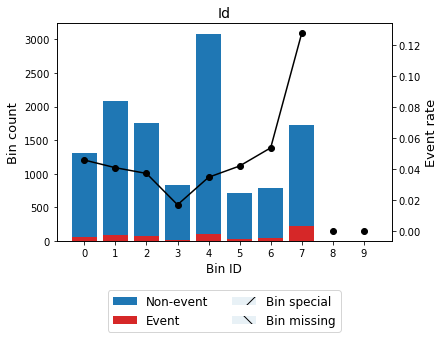

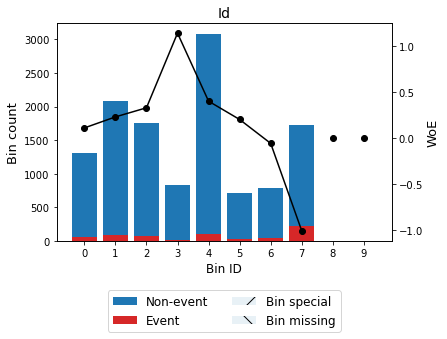

In [20]:
Id_tab.plot(metric="event_rate")
Id_tab.plot(metric="woe")

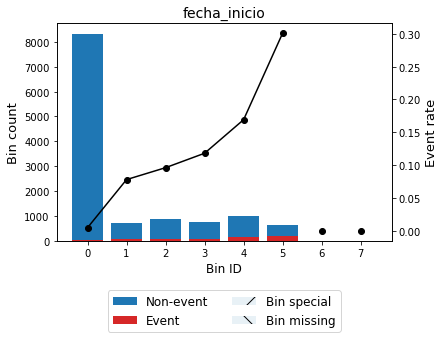

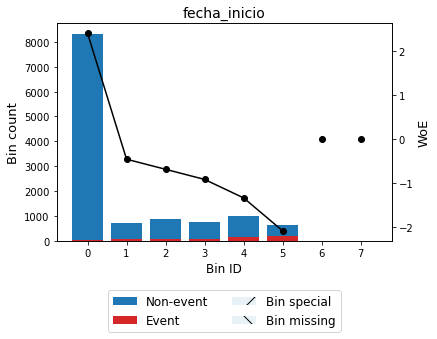

In [21]:
fecha_inicio_tab.plot(metric="event_rate")
fecha_inicio_tab.plot(metric="woe")

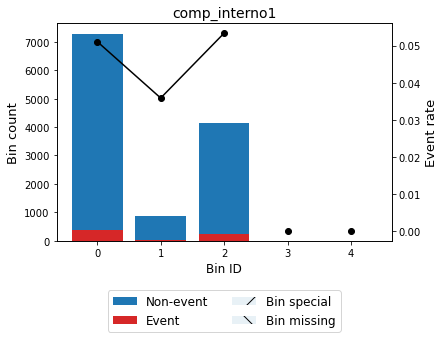

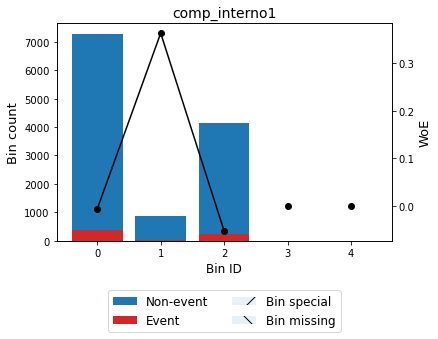

In [22]:
comp_interno1_tab.plot(metric="event_rate")
comp_interno1_tab.plot(metric="woe")

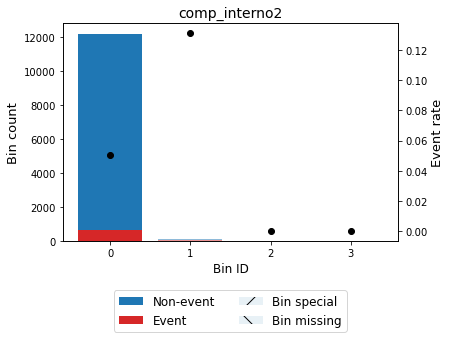

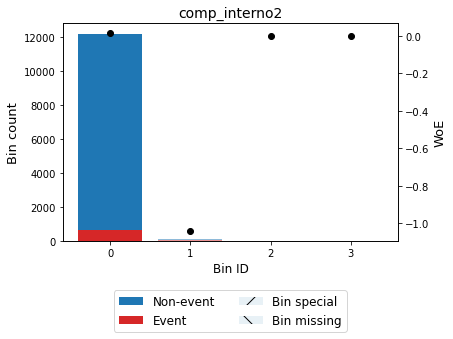

In [23]:
comp_interno2_tab.plot(metric="event_rate")
comp_interno2_tab.plot(metric="woe")

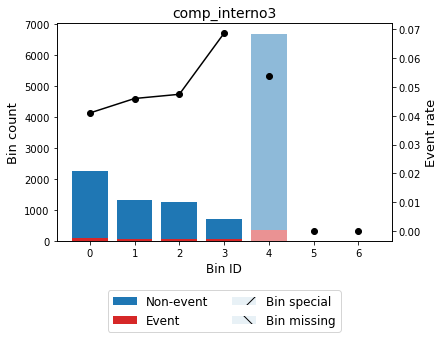

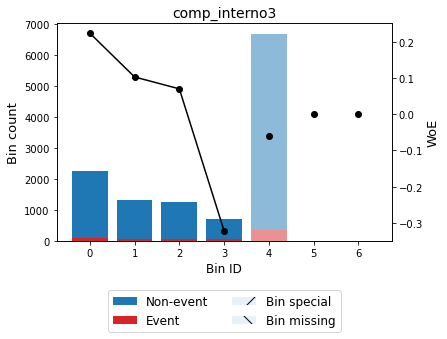

In [24]:
comp_interno3_tab.plot(metric="event_rate")
comp_interno3_tab.plot(metric="woe")

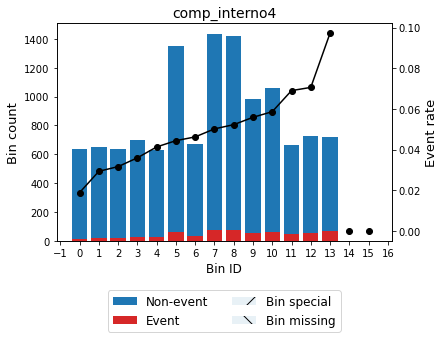

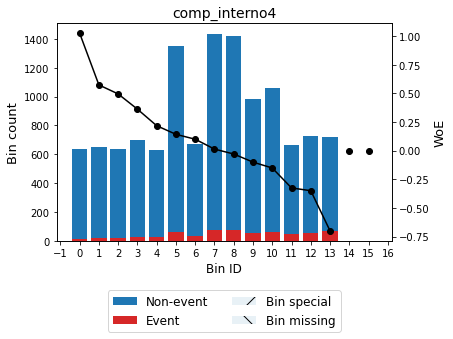

In [25]:
comp_interno4_tab.plot(metric="event_rate")
comp_interno4_tab.plot(metric="woe")

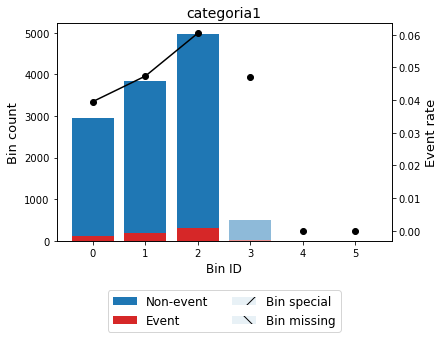

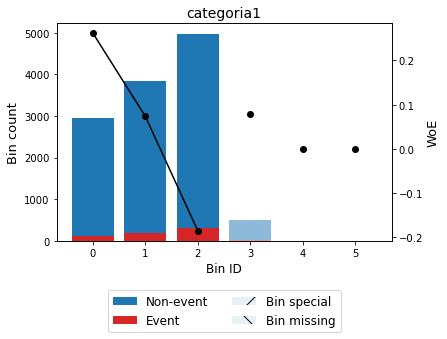

In [26]:
categoria1_tab.plot(metric="event_rate")
categoria1_tab.plot(metric="woe")

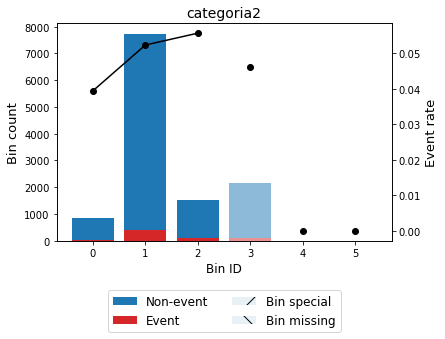

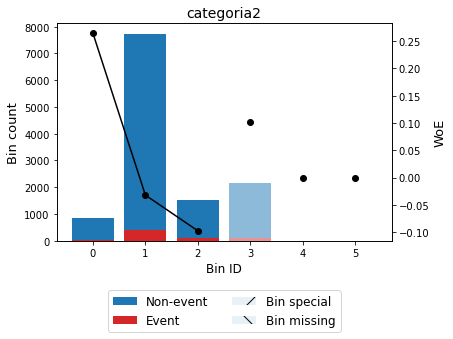

In [27]:
categoria2_tab.plot(metric="event_rate")
categoria2_tab.plot(metric="woe")

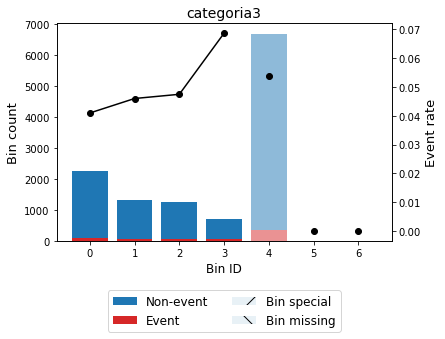

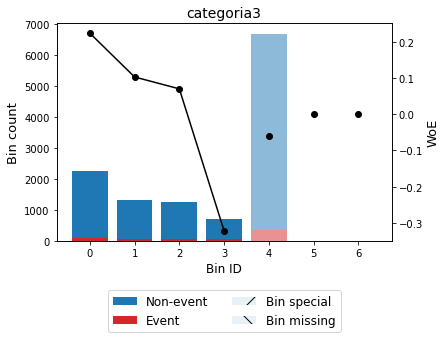

In [28]:
categoria3_tab.plot(metric="event_rate")
categoria3_tab.plot(metric="woe")

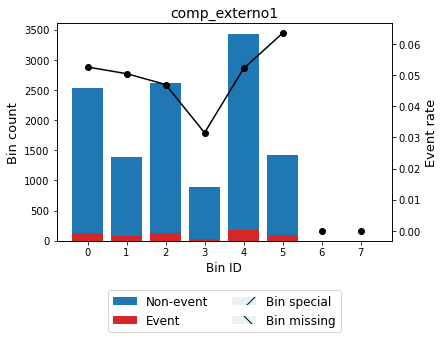

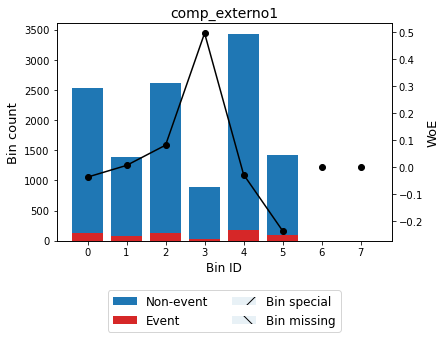

In [29]:
comp_externo1_tab.plot(metric="event_rate")
comp_externo1_tab.plot(metric="woe")

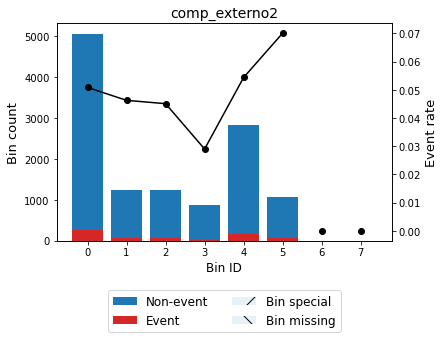

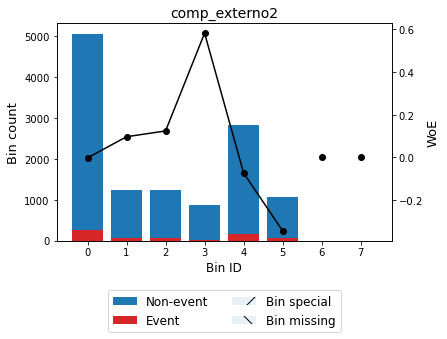

In [30]:
comp_externo2_tab.plot(metric="event_rate")
comp_externo2_tab.plot(metric="woe")

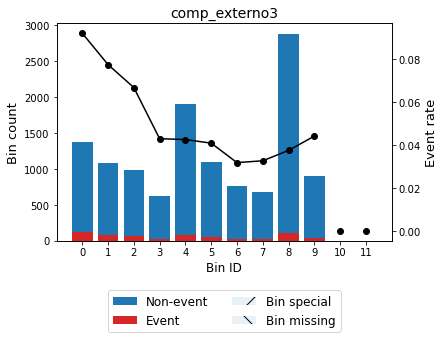

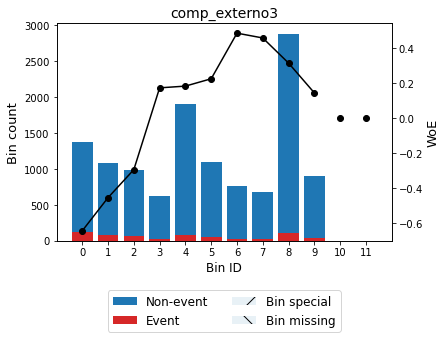

In [31]:
comp_externo3_tab.plot(metric="event_rate")
comp_externo3_tab.plot(metric="woe")

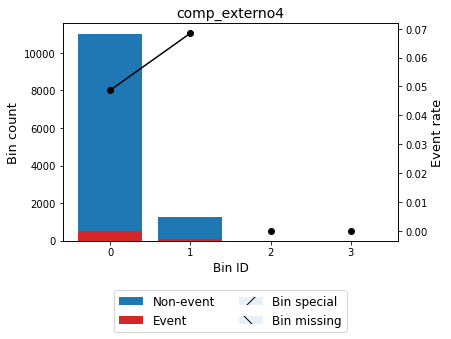

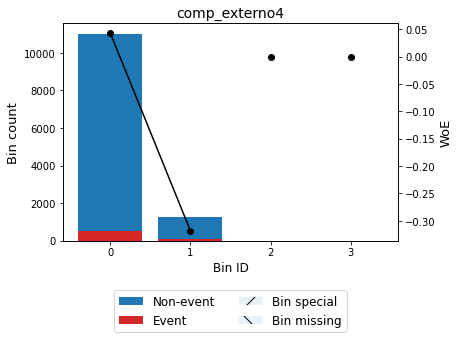

In [32]:
comp_externo4_tab.plot(metric="event_rate")
comp_externo4_tab.plot(metric="woe")

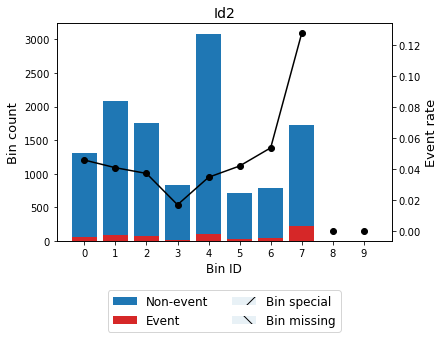

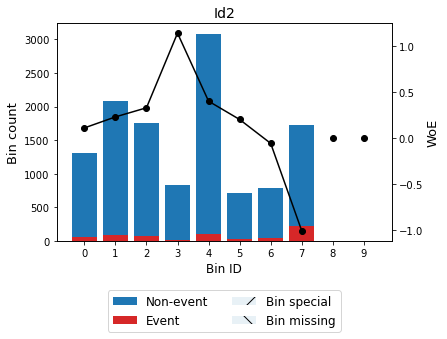

In [33]:
Id2_tab.plot(metric="event_rate")
Id2_tab.plot(metric="woe")

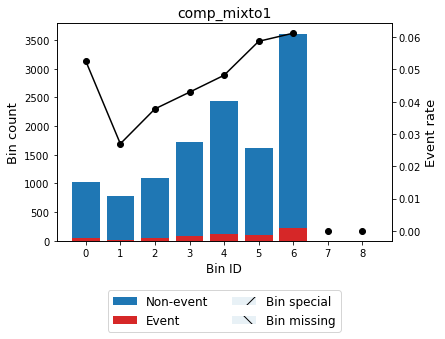

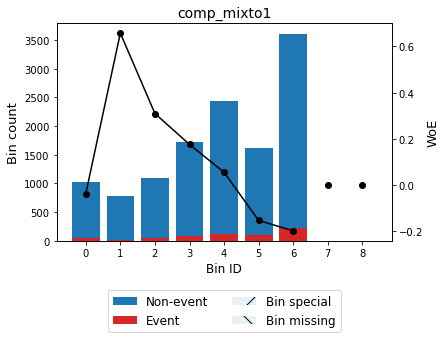

In [34]:
comp_mixto1_tab.plot(metric="event_rate")
comp_mixto1_tab.plot(metric="woe")

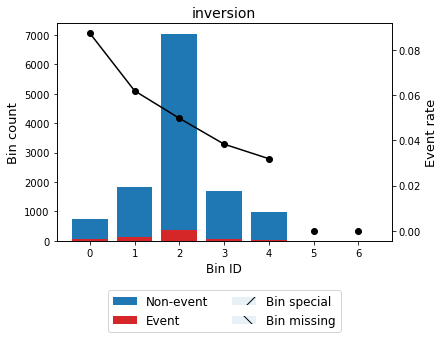

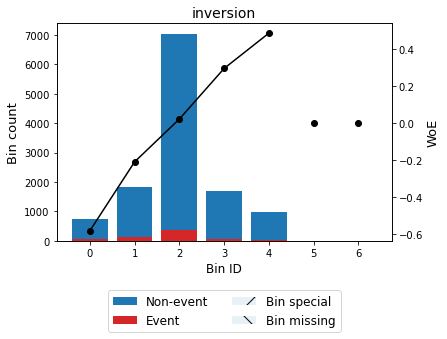

In [35]:
inversion_tab.plot(metric="event_rate")
inversion_tab.plot(metric="woe")

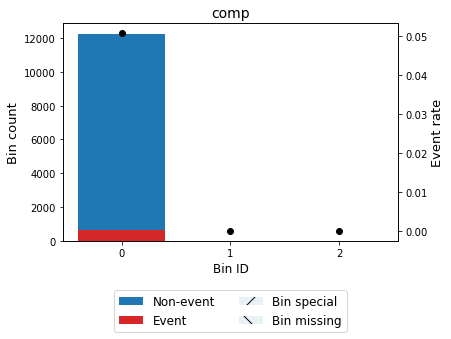

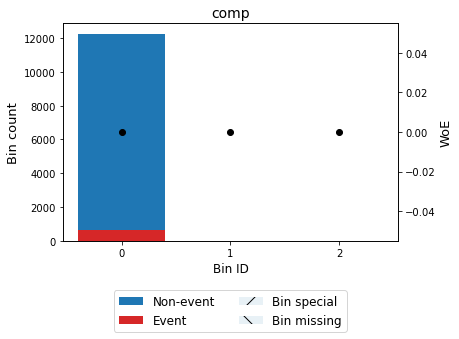

In [36]:
comp_tab.plot(metric="event_rate")
comp_tab.plot(metric="woe")

In [37]:
#Transformamos las variables a woe

train["woe_Id"] = optb_Id.transform(train['_id_'], metric="woe")
train["woe_fecha_inicio"] = optb_fecha_inicio.transform(train["fecha_inicio"], metric="woe")
train["woe_comp_interno1"] = optb_comp_interno1.transform(train["comp_interno1"], metric="woe")
train["woe_comp_interno2"] = optb_comp_interno2.transform(train["comp_interno2"], metric="woe")
train["woe_comp_interno3"] = optb_comp_interno3.transform(train["comp_interno3"], metric="woe")
train["woe_comp_interno4"] = optb_comp_interno4.transform(train['comp_interno4_y'], metric="woe")
train["woe_categoria1"] = optb_categoria1.transform(train["categoria1"], metric="woe")
train["woe_categoria2"] = optb_categoria2.transform(train["categoria2"], metric="woe")
train["woe_categoria3"] = optb_categoria3.transform(train["categoria3"], metric="woe")
train["woe_comp_externo1"] = optb_comp_externo1.transform(train["comp_externo1"], metric="woe")
train["woe_comp_externo2"] = optb_comp_externo2.transform(train["comp_externo2"], metric="woe")
train["woe_comp_externo3"] = optb_comp_externo3.transform(train["comp_externo3"], metric="woe")
train["woe_comp_externo4"] = optb_comp_externo4.transform(train["comp_externo4"], metric="woe")
train["woe_Id2"] = optb_Id2.transform(train['_id2_'], metric="woe")
train["woe_comp_mixto1"] = optb_comp_mixto1.transform(train["comp_mixto1"], metric="woe")
train["woe_inversion"] = optb_inversion.transform(train["inversion"], metric="woe")
train["woe_comp"] = optb_comp.transform(train["comp"], metric="woe")

<ipython-input-37-fe5e015a7fa5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["woe_Id"] = optb_Id.transform(train['_id_'], metric="woe")
<ipython-input-37-fe5e015a7fa5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["woe_fecha_inicio"] = optb_fecha_inicio.transform(train["fecha_inicio"], metric="woe")
<ipython-input-37-fe5e015a7fa5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [38]:
train.tail()

,_id_,comp_interno4_x,fecha_inicio,comp_interno1,comp_interno2,comp_interno3,comp_interno4_y,categoria1,categoria2,categoria3,...,woe_categoria2,woe_categoria3,woe_comp_externo1,woe_comp_externo2,woe_comp_externo3,woe_comp_externo4,woe_Id2,woe_comp_mixto1,woe_inversion,woe_comp
16304,93132,69.0,2021-01-08,0.000000,b'1',22.0,69.0,4.0,3.0,167.0,...,0.264405,-0.059841,-0.237067,-0.001808,0.486304,0.04273,-1.009094,-0.153470,0.295712,0.0
79,357,66.0,2016-01-08,1874.366768,b'1',11.0,66.0,2.0,9.0,156.0,...,-0.032161,-0.059841,0.005930,-0.001808,0.184005,0.04273,0.107868,-0.198264,0.022497,0.0
12119,63968,68.0,2019-05-21,15197.568389,b'1',31.0,68.0,1.0,6.0,176.0,...,-0.097552,-0.059841,-0.237067,-0.343432,-0.452749,0.04273,0.398163,-0.198264,0.022497,0.0
14147,77352,59.0,2020-01-22,0.000000,b'1',26.0,59.0,3.0,6.0,171.0,...,-0.097552,-0.059841,0.081173,-0.001808,0.315424,0.04273,-0.059706,-0.153470,0.022497,0.0
5640,27344,68.0,2017-06-23,962.512665,b'1',11.0,68.0,3.0,5.0,156.0,...,0.101930,-0.059841,-0.028125,-0.072667,0.315424,0.04273,0.326447,-0.037287,0.486392,0.0


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12275 entries, 15157 to 5640
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id_               12275 non-null  int64  
 1   comp_interno4_x    12275 non-null  float64
 2   fecha_inicio       12275 non-null  object 
 3   comp_interno1      12275 non-null  float64
 4   comp_interno2      12275 non-null  object 
 5   comp_interno3      12275 non-null  float64
 6   comp_interno4_y    12275 non-null  float64
 7   categoria1         12275 non-null  float64
 8   categoria2         12275 non-null  float64
 9   categoria3         12275 non-null  float64
 10  comp_externo1      12275 non-null  float64
 11  comp_externo2      12275 non-null  float64
 12  comp_externo3      12275 non-null  float64
 13  comp_externo4      12275 non-null  float64
 14  _id2_              12275 non-null  int64  
 15  comp_mixto1        12275 non-null  float64
 16  inversion          

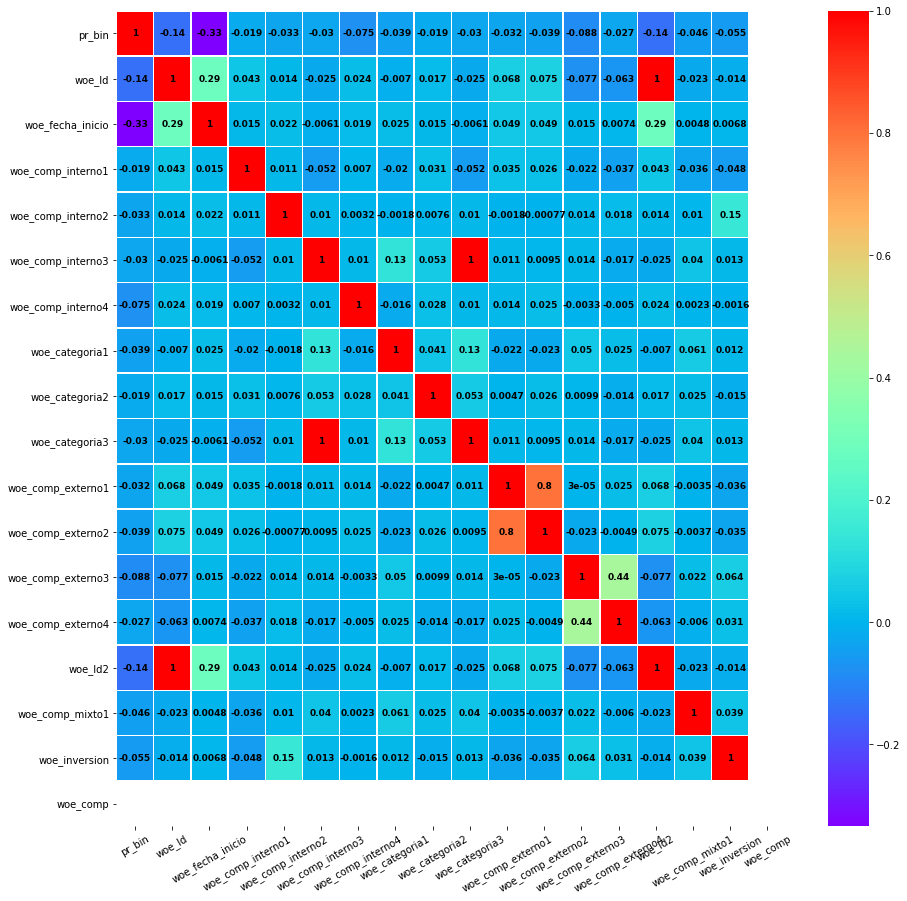

In [40]:
import matplotlib.pyplot as plt
corr = train.iloc[:,18:].corr()


xticks = list(corr.index)  
yticks = list(corr.index)  
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1, 1, 1)

sns.heatmap(corr,annot=True,cmap="rainbow",ax=ax1,linewidths=.5,annot_kws={'size':9,'weight':'bold', 'color':'k'})
ax1.set_xticklabels(xticks, rotation=30, fontsize=10)
ax1.set_yticklabels(yticks, rotation=0, fontsize=10)
plt.show()

Notamos que las variables woe_Id, woe_comp_interno3,woe_categoria3, woe_externo1 y woe_externo2 tienen correlaciones altas con otras variables, estas variables, altener una correlacion mayor o igual al 60% se descartan del modelo.

 El siguiente filtro será analizar los IV de cada una de las variables woe distintas a las que ya se descartaron, recoremos que si tenemos un IV menor al 2% se descartan, y si tenemos un IV mayor al 50% tampoco se consideran dentro del modelo, en este caso tenemos que la variable woe_fecha_inicio se descarta por tener un IV mayor al 200%. Woe_categoria2 y woe_externo4 se descartan por tener un IV menor al 2% y 1% respectivamente. 

In [41]:
ftrain=train[['pr_bin','woe_comp_interno4','woe_categoria1','woe_comp_externo3', 'woe_comp_mixto1', 'woe_inversion']]
X_woe_train = ftrain.iloc[:,1:]
y_train=y1.copy()
X_woe_train.head()

,woe_comp_interno4,woe_categoria1,woe_comp_externo3,woe_comp_mixto1,woe_inversion
15157,0.141689,-0.184957,0.486304,-0.198264,0.022497
1812,-0.100835,-0.184957,-0.452749,-0.198264,0.022497
13343,-0.100835,-0.184957,0.184005,0.055008,0.022497
4364,-0.030090,0.073617,-0.642102,0.175779,0.022497
8926,1.024158,-0.184957,0.458781,0.309513,0.022497


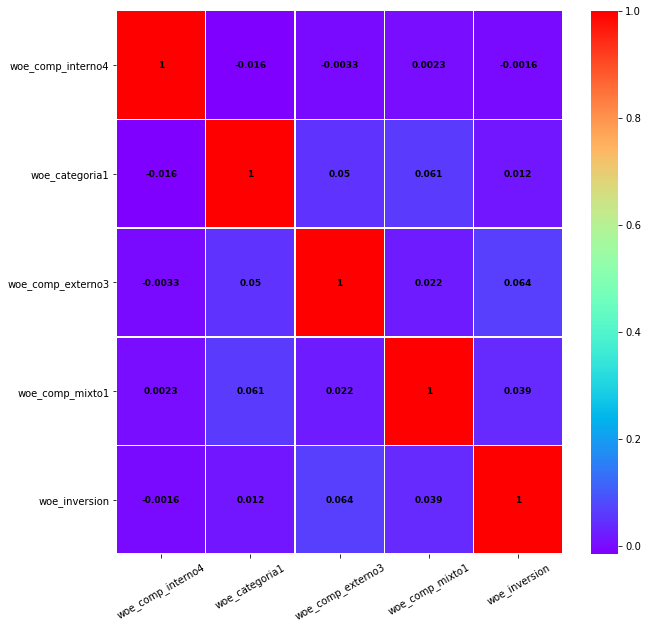

In [42]:
corr = ftrain.iloc[:,1:].corr()
corr

xticks = list(corr.index)  
yticks = list(corr.index)  
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)

sns.heatmap(corr,annot=True,cmap="rainbow",ax=ax1,linewidths=.5,annot_kws={'size':9,'weight':'bold', 'color':'k'})
ax1.set_xticklabels(xticks, rotation=30, fontsize=10)
ax1.set_yticklabels(yticks, rotation=0, fontsize=10)
plt.show()

In [43]:
model=LogisticRegression()
clf=model.fit(X_woe_train,y_train)

y_pred
 [0. 0. 0. ... 0. 0. 0.]
y_pred1
 [-3.2238518  -2.09463711 -2.91063032 ... -2.04183606 -3.21933946
 -3.68128207]


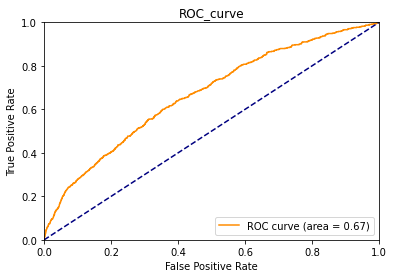

In [44]:
y_pred=clf.predict(X_woe_train)
y_pred1=clf.decision_function(X_woe_train)*1.0
print('y_pred\n',y_pred)
print('y_pred1\n',y_pred1)

#Curva ROC y el valor AUC
#fpr, tpr, thresholds = roc_curve(test_Y, pred_y)

fpr,tpr,threshold = roc_curve(y_train, y_pred1)
roc_auc = auc(fpr,tpr)
plot(fpr,tpr,color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
#ftrain=train[['pr_bin','woe_comp_interno4','woe_categoria1','woe_comp_externo3', 'woe_comp_mixto1', 'woe_inversion']]
#X_woe_train = ftrain.iloc[:,1:]
#y_train=y1.copy()
#X_woe_train.head()


ftest=test.iloc[:,[18,1,7,12,15,16]]
X_woe_test = ftest.iloc[:,1:]
y_test1=ftest.iloc[:,0]
X_woe_test.head()

,comp_interno4_x,categoria1,comp_externo3,comp_mixto1,inversion
3668,51.0,2.0,106.0,0.38000,567.480128
3732,69.0,3.0,118.0,0.33810,41.622824
5091,75.0,3.0,126.0,0.34000,66.586908
13822,59.0,2.0,64.0,0.23750,1079.512975
8331,59.0,2.0,96.0,0.33138,20.373909


y_pred
 [0. 0. 0. ... 0. 0. 0.]
y_pred1
 [-663.06787359 -224.41617388 -260.36708923 ... -186.04738662 -199.71219452
 -708.78559797]


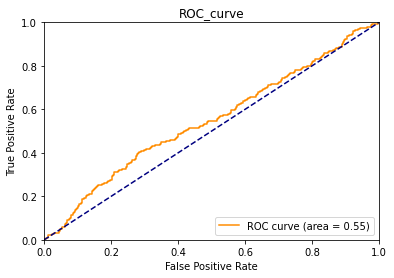

In [48]:
y_pred2=clf.predict(X_woe_test)
y_pred12=clf.decision_function(X_woe_test)*1.0
print('y_pred\n',y_pred2)
print('y_pred1\n',y_pred12)

#Curva ROC y el valor AUC
#fpr, tpr, thresholds = roc_curve(test_Y, pred_y)

fpr,tpr,threshold = roc_curve(y_test1, y_pred12)
roc_auc = auc(fpr,tpr)
plot(fpr,tpr,color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")
plt.show()

In [49]:
coe=model.coef_
coe[0]

array([-1.03049518, -0.82054398, -0.93636323, -0.86768533, -0.8922975 ])

## Estadistica KS 

$$ KS = max\{TPR - FPR\}$$

In [52]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test1, y_pred2)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)


diferencia_TPRFPR = TPR - FPR 

KS = max(diferencia_TPRFPR)
print(KS)

-0.007183894386928902


In [53]:
print(y_pred2)

[0. 0. 0. ... 0. 0. 0.]


## Coeficiente de Gini

Calculamos el coeficiente de gini


In [54]:
Gini_test= (2*roc_auc) - 1
Gini_test

0.0937804016262791

# E2

## árbol 1

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y)


In [56]:
dt = DecisionTreeClassifier(criterion="gini",splitter='best', min_samples_split=2, min_samples_leaf=1,random_state=52)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=52)

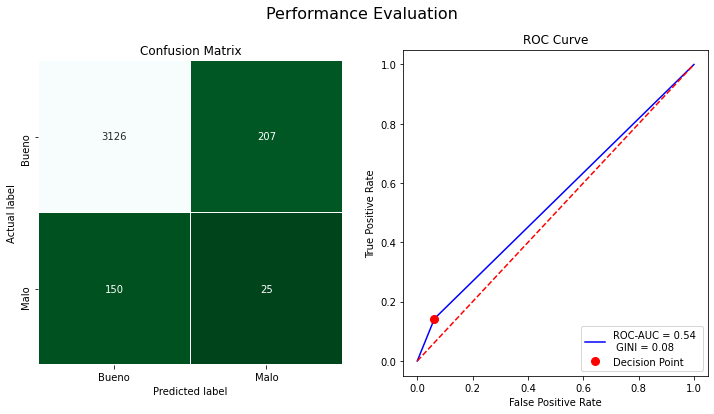

In [57]:
LABELS = ['Bueno', 'Malo']
tree_perf = performance_evaluation_report(dt, X_test,y_test, labels=LABELS,show_plot=True)

## árbol 2

In [58]:
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                                 RandomizedSearchCV,
                                                 cross_validate,
                                                 StratifiedKFold)

In [59]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [60]:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
               'classifier__max_depth': range(3, 11),
               'classifier__min_samples_leaf': range(2, 11)}

In [61]:
dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[('classifier', dec_tree)])

In [62]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid,scoring='recall',cv=k_fold, n_jobs=-1, verbose=1)
classifier_gs.fit(X_train, y_train)
#print(f'Best parameters: {classifier_gs.best_params_}')
#print(f'Recall (Training set): {classifier_gs.best_score_:.4f}')
#print(f'Recall (Test set): {metrics.recall_score(y_test,classifier_gs.predict(X_test)):.4f}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__max_depth': range(3, 11),
                         'classifier__min_samples_leaf': range(2, 11)},
             scoring='recall', verbose=1)

In [63]:
print(f'Best parameters: {classifier_gs.best_params_}') 
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}')

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3}
Recall (Training set): 0.0643
Recall (Test set): 0.0571


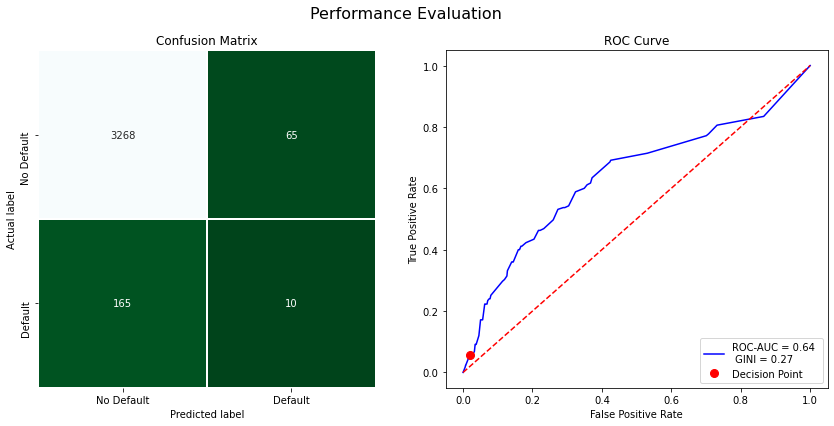

In [64]:
LABELS = ['No Default', 'Default']
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
#plt.savefig('images/ch8_im20.png')
plt.show()

In [65]:
dt2 = DecisionTreeClassifier(criterion="gini",max_depth = 10 ,splitter='best', min_samples_split=2, min_samples_leaf=5,random_state=52)
dt2.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=52)

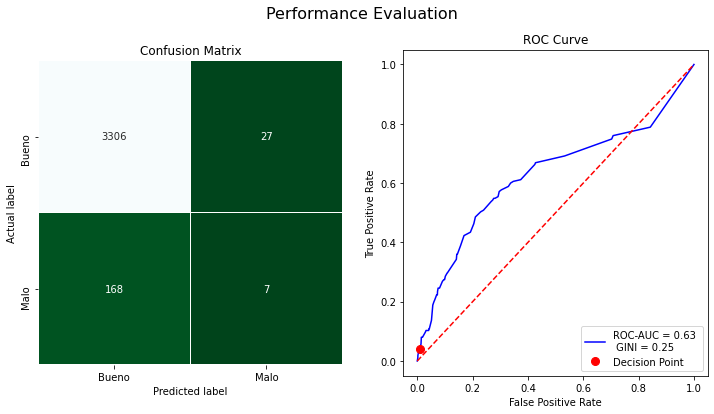

In [66]:
LABELS = ['Bueno', 'Malo']
tree_perf = performance_evaluation_report(dt2, X_test,y_test, labels=LABELS,show_plot=True)

# Ejercicio 3

In [67]:
from sklearn.model_selection import cross_val_score


clf = dt
scores = cross_val_score(clf, X, y, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf1 = dt2
scores1 = cross_val_score(clf1, X, y, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores1.mean(), scores1.std()))

clf2 = model
scores1 = cross_val_score(clf2, X, y, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores1.mean(), scores1.std()))

0.32 accuracy with a standard deviation of 0.34
0.34 accuracy with a standard deviation of 0.36
0.95 accuracy with a standard deviation of 0.00


El mejor modelo es la regresión logística hecha con WOE, obtuvo un accuracy de 0.95

### Ejercicio 4
Puntos Optimos de Decision

In [69]:
   #Encontraremos el punto optimo de decision
    
def punto_optimo_decision(model, X_test, y_test,y_pred12):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

#    cm = metrics.confusion_matrix(y_test, y_pred)
#    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred12)
#    roc_auc = metrics.auc(fpr, tpr)
#    ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')

# ROC-AUC
    RA =tpr-fpr
    ind = np.argmax(RA)
    punt_opt = thresholds[ind]
    
    pod.plot(fpr, tpr, 'b-', label='Reg_Logist')
#Labels    
    pod.set(xlabel='False Positive Rate',
              ylabel='True Positive Rate', title='ROC Curve')
#Puntos 
    plt.scatter(fpr[ind], tpr[ind], marker='o', color='black', label='Decision Point')
   # pod.plot(fp/(fp+tn), tp/(tp+fn), 'ro',
   #            markersize=8, label='Decision Point')
        
    pod.plot([0, 1], [0, 1], 'r--')
    pod.legend(loc='lower right')
    pod.show()
    
    return punt_opt
    
punto_optimo=punto_optimo_decision(model, X_woe_test, y_test1,y_pred12)
punto_optimo
print("El punto optimo de decision es: ", punto_optimo)
    

NameError: name 'thresholds' is not defined

AttributeError: module 'matplotlib.pyplot' has no attribute 'set'

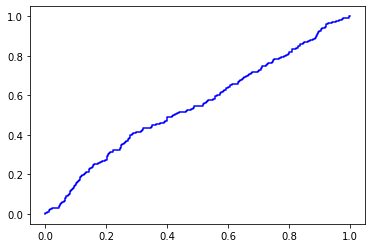

In [77]:
#punto_optimo_decision(model, X_woe_test, y_test1):
y_pred = model.predict(X_woe_test)
y_pred_prob = model.predict_proba( X_woe_test)[:, 1]

#    cm = metrics.confusion_matrix(y_test, y_pred)
#    tn, fp, fn, tp = cm.ravel()

fpr, tpr, threshold = metrics.roc_curve(y_test1, y_pred12)
#    roc_auc = metrics.auc(fpr, tpr)
#    ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')

# ROC-AUC
RA =tpr-fpr
ind = np.argmax(RA)
punt_opt = threshold[ind]
    
pod.plot(fpr, tpr, 'b-', label='Reg_Logist')
#Labels    
pod.set(xlabel='False Positive Rate',
ylabel='True Positive Rate', title='ROC Curve')
#Puntos 
plt.scatter(fpr[ind], tpr[ind], marker='o', color='black', label='Decision Point')
   # pod.plot(fp/(fp+tn), tp/(tp+fn), 'ro',
   #            markersize=8, label='Decision Point')
        
pod.plot([0, 1], [0, 1], 'r--')
pod.legend(loc='lower right')
pod.show()

In [73]:
y_pred = model.predict(X_woe_test)
y_pred_prob = model.predict_proba( X_woe_test)[:, 1]

#    cm = metrics.confusion_matrix(y_test, y_pred)
#    tn, fp, fn, tp = cm.ravel()

fpr, tpr, threshold = metrics.roc_curve(y_test1, y_pred12)

In [74]:
threshold

array([   527.26870663,    526.26870663,    514.01065976,    513.57869913,
          502.52268907,    502.51251686,    498.65984534,    498.4007978 ,
          497.40338356,    496.54963983,    486.93367085,    486.68647345,
          468.40741075,    468.21983178,    397.11240489,    394.02320132,
          -35.88903876,    -37.46042976,    -39.71074424,    -39.8337471 ,
          -51.11103506,    -51.13740226,    -54.12196047,    -54.98777326,
          -63.91450658,    -64.5714944 ,    -71.48066272,    -72.8623176 ,
          -76.06730912,    -76.23780546,    -86.29010814,    -87.03058941,
          -88.44549108,    -88.5130576 ,    -90.17852207,    -90.18179879,
          -90.27752697,    -90.39643133,    -92.62947434,    -92.88567499,
          -94.8452532 ,    -95.10604826,    -95.96820171,    -96.17282101,
         -101.0325891 ,   -101.37258802,   -101.95976734,   -102.00285332,
         -103.87014459,   -103.93610936,   -103.96697978,   -104.00809839,
         -104.57054968,  